In [1]:
from numpy import *
from cosmo import * 
from TLA   import *
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('tableau10.mplstyle')

# Three-Level Atom Integration

This part of the code 

In [2]:
def getfz():
    def fzHIon(rs,xe):
        return (1-xe)/3
    def fzHeIon(rs,xe):
        return 0
    def fzHLya(rs,xe):
        return (1-xe)/3
    def fzHeat(rs,xe):
        return (1+2*xe)/3
    return {'HIon':fzHIon, 'HeIon':fzHeIon, 'HLya':fzHLya, 'Heat':fzHeat}

def getinjrate(injType,injFac):
    def injrate(rs): 
        if injType == 'sWave':
            return injFac*(rs**6)
        elif injType == 'decay':
            return injFac*(rs**3)
    return injrate

initrs = 3000
initCond = [TCMB(initrs), 5]
rsVec = flipud(logspace(1,log10(initrs), num=2000))

ionThermHist = getIonThermHist(initrs,initCond,getfz(),getinjrate('decay',1/1e24),rsVec)
stdIonThermHist = getIonThermHist(initrs,initCond,getfz(),getinjrate('decay',1/1e24),rsVec)


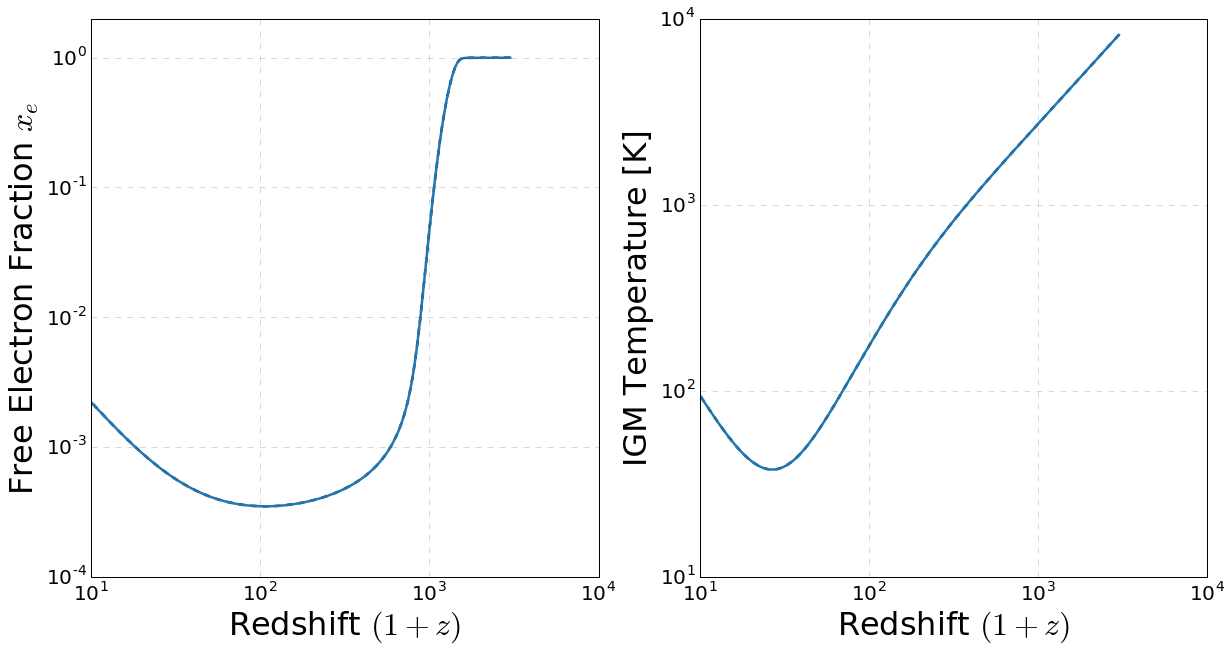

In [4]:
plt.figure(figsize=(20,10))

plt.subplot(121)
plt.plot(rsVec,0.5+0.5*tanh(stdIonThermHist[:,1]),linestyle='dashed',color='black')
plt.plot(rsVec,0.5+0.5*tanh(ionThermHist[:,1]))
plt.xlabel('Redshift '+'$(1+z)$')
plt.ylabel('Free Electron Fraction $x_e$')
plt.ylim([1e-4,2])
plt.xscale('log')
plt.yscale('log')

plt.subplot(122)
plt.plot(rsVec,stdIonThermHist[:,0]/kB,linestyle='dashed',color='black')
plt.plot(rsVec,ionThermHist[:,0]/kB)
plt.xlabel('Redshift $(1+z)$')
plt.ylabel('IGM Temperature [K]')
plt.xscale('log')
plt.yscale('log')

plt.show()